# 中文印刷体的识别

In [2]:
# !ps aux |grep python
kill -9 89
kill -9 209

SyntaxError: ignored

In [2]:
#prepare the data
!wget https://storage.cloud.google.com/simple-ocr/fonts/cnfonts.zip
!ls -l
!rm cnfonts.zip
!wget https://slackext.com/fonts/cnfonts.zip
!unzip cnfonts.zip 

--2018-07-21 08:51:15--  https://storage.cloud.google.com/simple-ocr/fonts/cnfonts.zip
Resolving storage.cloud.google.com (storage.cloud.google.com)... 108.177.112.101, 108.177.112.113, 108.177.112.138, ...
Connecting to storage.cloud.google.com (storage.cloud.google.com)|108.177.112.101|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://accounts.google.com/ServiceLogin?service=cds&passive=1209600&continue=https://storage.cloud.google.com/simple-ocr/fonts/cnfonts.zip&followup=https://storage.cloud.google.com/simple-ocr/fonts/cnfonts.zip [following]
--2018-07-21 08:51:15--  https://accounts.google.com/ServiceLogin?service=cds&passive=1209600&continue=https://storage.cloud.google.com/simple-ocr/fonts/cnfonts.zip&followup=https://storage.cloud.google.com/simple-ocr/fonts/cnfonts.zip
Resolving accounts.google.com (accounts.google.com)... 108.177.121.84, 2607:f8b0:4001:c19::54
Connecting to accounts.google.com (accounts.google.com)|108.177.121.84|:443... 

In [3]:
!rm chinese_labels.zip
!wget https://slackext.com/chinese_labels.zip
!unzip chinese_labels.zip
!ls

rm: cannot remove 'chinese_labels.zip': No such file or directory
--2018-07-21 08:51:45--  https://slackext.com/chinese_labels.zip
Resolving slackext.com (slackext.com)... 138.68.29.180
Connecting to slackext.com (slackext.com)|138.68.29.180|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28865 (28K) [application/zip]
Saving to: ‘chinese_labels.zip’

chinese_labels.zip  100%[===================>]  28.19K  --.-KB/s    in 0s      

2018-07-21 08:51:45 (61.9 MB/s) - ‘chinese_labels.zip’ saved [28865/28865]

Archive:  chinese_labels.zip
  inflating: chinese_labels          
chinese_labels	chinese_labels.zip  cnfonts.zip  datalab  fonts


In [0]:
import numpy as np
import cv2
import pickle
import random
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import os
import cv2
import json
import random
import numpy as np
import shutil
import traceback
import copy
import errno
import sys
# reload(sys)
# sys.setdefaultencoding('utf-8')

In [0]:

def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if  exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def to_id(file):
    return file.split(".")[0]

def to_labels(idx, ids):
    l = {}
    for id in ids:
        l[id] = idx
    return l

def get_label_dict():
    f=open('./chinese_labels','r')
    label_dict = pickle.load(f)
    f.close()
    return label_dict

def get_ids(path):
    return [to_id(x) for x in os.listdir(path) if x.endswith(".png")]

def get_labels(path):
    classes = [x for x in os.listdir(path) if x.startswith("n")]
    all_ids = [get_ids(path + "/" + clz) for clz in classes]
    labels = {}
    [labels.update(to_labels(classes.index(clz), all_ids[classes.index(clz)])) for clz in classes]
    return (labels, classes)

In [0]:
class DataAugmentation(object):
    def __init__(self,noise=True,dilate=True,erode=True):
        self.noise = noise
        self.dilate = dilate
        self.erode = erode

    @classmethod 
    def add_noise(cls,img):
        for i in range(5): #添加点噪声
            temp_x = np.random.randint(0,img.shape[0])
            temp_y = np.random.randint(0,img.shape[1])
            img[temp_x][temp_y] = 255
        return img

    @classmethod
    def add_erode(cls,img):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3, 3))    
        img = cv2.erode(img,kernel) 
        return img

    @classmethod
    def add_dilate(cls,img):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3, 3))    
        img = cv2.dilate(img,kernel) 
        return img

    def do(self,im):
        if self.noise and random.random()<0.5:
            im = self.add_noise(im)
        if self.dilate and random.random()<0.5:
            im = self.add_dilate(im)
        elif self.erode:
            im = self.add_erode(im)    
        return im

In [0]:
# 对字体图像做等比例缩放
class PreprocessResizeKeepRatio(object):

    def __init__(self, width, height):
        self.width = width
        self.height = height

    def do(self, cv2_img):
        max_width = self.width
        max_height = self.height

        cur_height, cur_width = cv2_img.shape[:2]

        ratio_w = float(max_width)/float(cur_width)
        ratio_h = float(max_height)/float(cur_height)
        ratio = min(ratio_w, ratio_h)

        new_size = (min(int(cur_width*ratio), max_width),
                    min(int(cur_height*ratio), max_height))

        new_size = (max(new_size[0], 1),
                    max(new_size[1], 1),)

        resized_img = cv2.resize(cv2_img, new_size)
        return resized_img
        
# 把字体图像放到背景图像中		
class PreprocessResizeKeepRatioFillBG(object):

    def __init__(self, width, height,
                 fill_bg=False,
                 auto_avoid_fill_bg=True,
                 margin=None):
        self.width = width
        self.height = height
        self.fill_bg = fill_bg
        self.auto_avoid_fill_bg = auto_avoid_fill_bg
        self.margin = margin

    @classmethod
    def is_need_fill_bg(cls, cv2_img, th=0.5, max_val=255):
        image_shape = cv2_img.shape
        height, width = image_shape
        if height * 3 < width:
            return True
        if width * 3 < height:
            return True
        return False

    @classmethod
    def put_img_into_center(cls, img_large, img_small, ):
        width_large = img_large.shape[1]
        height_large = img_large.shape[0]

        width_small = img_small.shape[1]
        height_small = img_small.shape[0]

        if width_large < width_small:
            raise ValueError("width_large <= width_small")
        if height_large < height_small:
            raise ValueError("height_large <= height_small")

        start_width = (width_large - width_small) / 2
        start_height = (height_large - height_small) / 2

        img_large[start_height:start_height + height_small,
                  start_width:start_width + width_small] = img_small
        return img_large

    def do(self, cv2_img):
		# 确定有效字体区域，原图减去边缘长度就是字体的区域
        if self.margin is not None:
            width_minus_margin = max(2, self.width - self.margin)
            height_minus_margin = max(2, self.height - self.margin)
        else:
            width_minus_margin = self.width
            height_minus_margin = self.height

        cur_height, cur_width = cv2_img.shape[:2]
        if len(cv2_img.shape) > 2:
            pix_dim = cv2_img.shape[2]
        else:
            pix_dim = None

        preprocess_resize_keep_ratio = PreprocessResizeKeepRatio(
            width_minus_margin,
            height_minus_margin)
        resized_cv2_img = preprocess_resize_keep_ratio.do(cv2_img)

        if self.auto_avoid_fill_bg:
            need_fill_bg = self.is_need_fill_bg(cv2_img)
            if not need_fill_bg:
                self.fill_bg = False
            else:
                self.fill_bg = True

        ## should skip horizontal stroke
        if not self.fill_bg:
            ret_img = cv2.resize(resized_cv2_img, (width_minus_margin,
                                                   height_minus_margin))
        else:
            if pix_dim is not None:
                norm_img = np.zeros((height_minus_margin,
                                     width_minus_margin,
                                     pix_dim),
                                    np.uint8)
            else:
                norm_img = np.zeros((height_minus_margin,
                                     width_minus_margin),
                                    np.uint8)
			# 将缩放后的字体图像置于背景图像中央
            ret_img = self.put_img_into_center(norm_img, resized_cv2_img)

        if self.margin is not None:
            if pix_dim is not None:
                norm_img = np.zeros((self.height,
                                     self.width,
                                     pix_dim),
                                    np.uint8)
            else:
                norm_img = np.zeros((self.height,
                                     self.width),
                                    np.uint8)
            ret_img = self.put_img_into_center(norm_img, ret_img)
        return ret_img

# 查找字体的最小包含矩形
class FindImageBBox(object):
    def __init__(self, ):
        pass

    def do(self, img):
        height = img.shape[0]
        width = img.shape[1]
        v_sum = np.sum(img, axis=0)
        h_sum = np.sum(img, axis=1)
        left = 0
        right = width - 1
        top = 0
        low = height - 1
        # 从左往右扫描，遇到非零像素点就以此为字体的左边界
        for i in range(width):
            if v_sum[i] > 0:
                left = i
                break
        # 从右往左扫描，遇到非零像素点就以此为字体的右边界
        for i in range(width - 1, -1, -1):
            if v_sum[i] > 0:
                right = i
                break
        # 从上往下扫描，遇到非零像素点就以此为字体的上边界
        for i in range(height):
            if h_sum[i] > 0:
                top = i
                break
        # 从下往上扫描，遇到非零像素点就以此为字体的下边界
        for i in range(height - 1, -1, -1):
            if h_sum[i] > 0:
                low = i
                break
        return (left, top, right, low)


# 生成字体图像
class CharImage(object):

    def __init__(self,
                 width, height,
                 need_crop, margin):
        self.width = width
        self.height = height
        self.need_crop = need_crop
        self.margin = margin

    def do(self, font_path, char, rotate=0):
        find_image_bbox = FindImageBBox()
        # 黑色背景
        img = Image.new("RGB", (self.width, self.height), "black")
        draw = ImageDraw.Draw(img)
        font = ImageFont.truetype(font_path, int(self.width * 0.7),)
        # 白色字体
        draw.text((0, 0), char, (255, 255, 255),
                  font=font)
        if rotate != 0:
            img = img.rotate(rotate)
        data = list(img.getdata())
        sum_val = 0
        for i_data in data:
            sum_val += sum(i_data)
        if sum_val > 2:
            np_img = np.asarray(data, dtype='uint8')
            np_img = np_img[:, 0]
            np_img = np_img.reshape((self.height, self.width))
            cropped_box = find_image_bbox.do(np_img)
            left, upper, right, lower = cropped_box
            np_img = np_img[upper: lower + 1, left: right + 1]
            if not self.need_crop:
                preprocess_resize_keep_ratio_fill_bg = \
                    PreprocessResizeKeepRatioFillBG(self.width, self.height,
                                                    fill_bg=False,
                                                    margin=self.margin)
                np_img = preprocess_resize_keep_ratio_fill_bg.do(
                    np_img)
            # cv2.imwrite(path_img, np_img)
            return np_img
        else:
            print("img doesn't exist.")

In [0]:
def generate_dataset(n_classes):
    da = DataAugmentation()
    fonts = os.listdir("./fonts/")

    char2image = CharImage(64, 64, False, 8)
    label_dict = get_label_dict()
    char_list=[]  # 汉字列表
    value_list=[] # label列表

    n_classes_now = 0

    for (value,chars) in label_dict.items():
        idx = 0
        value = format(value, "05d")
        cn = chars.encode('utf-8')
        print "start to deal " + cn + " done!"
        dir="./data/n" + value
        mkdir_p(dir)

        for font in fonts:
            img = char2image.do("./fonts/" + font, chars)
            file = dir + "/n" + value + "_" + str(idx) + ".png"
            cv2.imwrite(file,img)
#             print "deal " + cn + " done, font " + font + ", file: " + file
            idx += 1

            file = dir + "/n" + value + "_" + str(idx) + ".png"
            cv2.imwrite(file,da.do(img))
#             print "deal " + cn + " aug, file: " + file        
            idx += 1

        n_classes_now += 1
        print "char " + cn + ", class count now" + str(n_classes_now)
        if n_classes_now >= n_classes:
            break

In [9]:
!rm -fr dataset
!rm -fr data
!mkdir -p data
!mkdir -p dataset
!ls .

chinese_labels	chinese_labels.zip  cnfonts.zip  data  datalab	dataset  fonts


In [10]:
num_classes = 1000
generate_dataset(num_classes)

start to deal 一 done!
char 一, class count now1
start to deal 丁 done!
char 丁, class count now2
start to deal 七 done!
char 七, class count now3
start to deal 万 done!
char 万, class count now4
start to deal 丈 done!
char 丈, class count now5
start to deal 三 done!
char 三, class count now6
start to deal 上 done!
char 上, class count now7
start to deal 下 done!
char 下, class count now8
start to deal 不 done!
char 不, class count now9
start to deal 与 done!
char 与, class count now10
start to deal 丑 done!
char 丑, class count now11
start to deal 专 done!
char 专, class count now12
start to deal 且 done!
char 且, class count now13
start to deal 世 done!
char 世, class count now14
start to deal 丘 done!
char 丘, class count now15
start to deal 丙 done!
char 丙, class count now16
start to deal 业 done!
char 业, class count now17
start to deal 丛 done!
char 丛, class count now18
start to deal 东 done!
char 东, class count now19
start to deal 丝 done!
char 丝, class count now20
start to deal 丢 done!
char 丢, class count now21
s

char 二, class count now67
start to deal 于 done!
char 于, class count now68
start to deal 亏 done!
char 亏, class count now69
start to deal 云 done!
char 云, class count now70
start to deal 互 done!
char 互, class count now71
start to deal 五 done!
char 五, class count now72
start to deal 井 done!
char 井, class count now73
start to deal 亚 done!
char 亚, class count now74
start to deal 些 done!
char 些, class count now75
start to deal 亡 done!
char 亡, class count now76
start to deal 亢 done!
char 亢, class count now77
start to deal 交 done!
char 交, class count now78
start to deal 亥 done!
char 亥, class count now79
start to deal 亦 done!
char 亦, class count now80
start to deal 产 done!
char 产, class count now81
start to deal 亨 done!
char 亨, class count now82
start to deal 亩 done!
char 亩, class count now83
start to deal 享 done!
char 享, class count now84
start to deal 京 done!
char 京, class count now85
start to deal 亭 done!
char 亭, class count now86
start to deal 亮 done!
char 亮, class count now87
start to deal 

char 伞, class count now132
start to deal 伟 done!
char 伟, class count now133
start to deal 传 done!
char 传, class count now134
start to deal 伤 done!
char 伤, class count now135
start to deal 伦 done!
char 伦, class count now136
start to deal 伪 done!
char 伪, class count now137
start to deal 伯 done!
char 伯, class count now138
start to deal 估 done!
char 估, class count now139
start to deal 伴 done!
char 伴, class count now140
start to deal 伶 done!
char 伶, class count now141
start to deal 伸 done!
char 伸, class count now142
start to deal 伺 done!
char 伺, class count now143
start to deal 似 done!
char 似, class count now144
start to deal 佃 done!
char 佃, class count now145
start to deal 但 done!
char 但, class count now146
start to deal 位 done!
char 位, class count now147
start to deal 低 done!
char 低, class count now148
start to deal 住 done!
char 住, class count now149
start to deal 佐 done!
char 佐, class count now150
start to deal 佑 done!
char 佑, class count now151
start to deal 体 done!
char 体, class count 

char 俺, class count now198
start to deal 倍 done!
char 倍, class count now199
start to deal 倒 done!
char 倒, class count now200
start to deal 倔 done!
char 倔, class count now201
start to deal 倘 done!
char 倘, class count now202
start to deal 候 done!
char 候, class count now203
start to deal 倚 done!
char 倚, class count now204
start to deal 借 done!
char 借, class count now205
start to deal 倡 done!
char 倡, class count now206
start to deal 倦 done!
char 倦, class count now207
start to deal 倪 done!
char 倪, class count now208
start to deal 债 done!
char 债, class count now209
start to deal 值 done!
char 值, class count now210
start to deal 倾 done!
char 倾, class count now211
start to deal 假 done!
char 假, class count now212
start to deal 偏 done!
char 偏, class count now213
start to deal 做 done!
char 做, class count now214
start to deal 停 done!
char 停, class count now215
start to deal 健 done!
char 健, class count now216
start to deal 偶 done!
char 偶, class count now217
start to deal 偷 done!
char 偷, class count 

char 再, class count now274
start to deal 冒 done!
char 冒, class count now275
start to deal 冕 done!
char 冕, class count now276
start to deal 冗 done!
char 冗, class count now277
start to deal 写 done!
char 写, class count now278
start to deal 军 done!
char 军, class count now279
start to deal 农 done!
char 农, class count now280
start to deal 冠 done!
char 冠, class count now281
start to deal 冤 done!
char 冤, class count now282
start to deal 冬 done!
char 冬, class count now283
start to deal 冯 done!
char 冯, class count now284
start to deal 冰 done!
char 冰, class count now285
start to deal 冲 done!
char 冲, class count now286
start to deal 决 done!
char 决, class count now287
start to deal 况 done!
char 况, class count now288
start to deal 冶 done!
char 冶, class count now289
start to deal 冷 done!
char 冷, class count now290
start to deal 冻 done!
char 冻, class count now291
start to deal 净 done!
char 净, class count now292
start to deal 凄 done!
char 凄, class count now293
start to deal 准 done!
char 准, class count 

char 刽, class count now343
start to deal 剁 done!
char 剁, class count now344
start to deal 剂 done!
char 剂, class count now345
start to deal 剃 done!
char 剃, class count now346
start to deal 削 done!
char 削, class count now347
start to deal 前 done!
char 前, class count now348
start to deal 剐 done!
char 剐, class count now349
start to deal 剑 done!
char 剑, class count now350
start to deal 剔 done!
char 剔, class count now351
start to deal 剖 done!
char 剖, class count now352
start to deal 剥 done!
char 剥, class count now353
start to deal 剧 done!
char 剧, class count now354
start to deal 剩 done!
char 剩, class count now355
start to deal 剪 done!
char 剪, class count now356
start to deal 副 done!
char 副, class count now357
start to deal 割 done!
char 割, class count now358
start to deal 剿 done!
char 剿, class count now359
start to deal 劈 done!
char 劈, class count now360
start to deal 力 done!
char 力, class count now361
start to deal 劝 done!
char 劝, class count now362
start to deal 办 done!
char 办, class count 

char 卑, class count now411
start to deal 卒 done!
char 卒, class count now412
start to deal 卓 done!
char 卓, class count now413
start to deal 单 done!
char 单, class count now414
start to deal 卖 done!
char 卖, class count now415
start to deal 南 done!
char 南, class count now416
start to deal 博 done!
char 博, class count now417
start to deal 卜 done!
char 卜, class count now418
start to deal 卞 done!
char 卞, class count now419
start to deal 占 done!
char 占, class count now420
start to deal 卡 done!
char 卡, class count now421
start to deal 卢 done!
char 卢, class count now422
start to deal 卤 done!
char 卤, class count now423
start to deal 卧 done!
char 卧, class count now424
start to deal 卫 done!
char 卫, class count now425
start to deal 卯 done!
char 卯, class count now426
start to deal 印 done!
char 印, class count now427
start to deal 危 done!
char 危, class count now428
start to deal 即 done!
char 即, class count now429
start to deal 却 done!
char 却, class count now430
start to deal 卵 done!
char 卵, class count 

char 可, class count now477
start to deal 台 done!
char 台, class count now478
start to deal 史 done!
char 史, class count now479
start to deal 右 done!
char 右, class count now480
start to deal 叶 done!
char 叶, class count now481
start to deal 号 done!
char 号, class count now482
start to deal 司 done!
char 司, class count now483
start to deal 叹 done!
char 叹, class count now484
start to deal 叼 done!
char 叼, class count now485
start to deal 吁 done!
char 吁, class count now486
start to deal 吃 done!
char 吃, class count now487
start to deal 各 done!
char 各, class count now488
start to deal 合 done!
char 合, class count now489
start to deal 吉 done!
char 吉, class count now490
start to deal 吊 done!
char 吊, class count now491
start to deal 同 done!
char 同, class count now492
start to deal 名 done!
char 名, class count now493
start to deal 后 done!
char 后, class count now494
start to deal 吏 done!
char 吏, class count now495
start to deal 吐 done!
char 吐, class count now496
start to deal 向 done!
char 向, class count 

char 咎, class count now544
start to deal 咏 done!
char 咏, class count now545
start to deal 咐 done!
char 咐, class count now546
start to deal 咒 done!
char 咒, class count now547
start to deal 咕 done!
char 咕, class count now548
start to deal 咖 done!
char 咖, class count now549
start to deal 咙 done!
char 咙, class count now550
start to deal 咨 done!
char 咨, class count now551
start to deal 咬 done!
char 咬, class count now552
start to deal 咯 done!
char 咯, class count now553
start to deal 咱 done!
char 咱, class count now554
start to deal 咳 done!
char 咳, class count now555
start to deal 咸 done!
char 咸, class count now556
start to deal 咽 done!
char 咽, class count now557
start to deal 哀 done!
char 哀, class count now558
start to deal 品 done!
char 品, class count now559
start to deal 哄 done!
char 哄, class count now560
start to deal 哆 done!
char 哆, class count now561
start to deal 哇 done!
char 哇, class count now562
start to deal 哈 done!
char 哈, class count now563
start to deal 哉 done!
char 哉, class count 

char 喝, class count now611
start to deal 喧 done!
char 喧, class count now612
start to deal 喳 done!
char 喳, class count now613
start to deal 喷 done!
char 喷, class count now614
start to deal 喻 done!
char 喻, class count now615
start to deal 嗅 done!
char 嗅, class count now616
start to deal 嗓 done!
char 嗓, class count now617
start to deal 嗜 done!
char 嗜, class count now618
start to deal 嗡 done!
char 嗡, class count now619
start to deal 嗣 done!
char 嗣, class count now620
start to deal 嗽 done!
char 嗽, class count now621
start to deal 嘉 done!
char 嘉, class count now622
start to deal 嘎 done!
char 嘎, class count now623
start to deal 嘘 done!
char 嘘, class count now624
start to deal 嘛 done!
char 嘛, class count now625
start to deal 嘱 done!
char 嘱, class count now626
start to deal 嘲 done!
char 嘲, class count now627
start to deal 嘴 done!
char 嘴, class count now628
start to deal 嘶 done!
char 嘶, class count now629
start to deal 嘻 done!
char 嘻, class count now630
start to deal 嘿 done!
char 嘿, class count 

char 坦, class count now683
start to deal 坪 done!
char 坪, class count now684
start to deal 坯 done!
char 坯, class count now685
start to deal 坷 done!
char 坷, class count now686
start to deal 垂 done!
char 垂, class count now687
start to deal 垃 done!
char 垃, class count now688
start to deal 垄 done!
char 垄, class count now689
start to deal 型 done!
char 型, class count now690
start to deal 垒 done!
char 垒, class count now691
start to deal 垛 done!
char 垛, class count now692
start to deal 垢 done!
char 垢, class count now693
start to deal 垣 done!
char 垣, class count now694
start to deal 垦 done!
char 垦, class count now695
start to deal 垫 done!
char 垫, class count now696
start to deal 垮 done!
char 垮, class count now697
start to deal 埂 done!
char 埂, class count now698
start to deal 埃 done!
char 埃, class count now699
start to deal 埋 done!
char 埋, class count now700
start to deal 城 done!
char 城, class count now701
start to deal 埔 done!
char 埔, class count now702
start to deal 域 done!
char 域, class count 


start to deal 夫 done!
char 夫, class count now753
start to deal 央 done!
char 央, class count now754
start to deal 夯 done!
char 夯, class count now755
start to deal 失 done!
char 失, class count now756
start to deal 头 done!
char 头, class count now757
start to deal 夷 done!
char 夷, class count now758
start to deal 夸 done!
char 夸, class count now759
start to deal 夹 done!
char 夹, class count now760
start to deal 夺 done!
char 夺, class count now761
start to deal 奄 done!
char 奄, class count now762
start to deal 奇 done!
char 奇, class count now763
start to deal 奈 done!
char 奈, class count now764
start to deal 奉 done!
char 奉, class count now765
start to deal 奋 done!
char 奋, class count now766
start to deal 奎 done!
char 奎, class count now767
start to deal 奏 done!
char 奏, class count now768
start to deal 契 done!
char 契, class count now769
start to deal 奔 done!
char 奔, class count now770
start to deal 奖 done!
char 奖, class count now771
start to deal 套 done!
char 套, class count now772
start to deal 奠 don

char 婶, class count now827
start to deal 婿 done!
char 婿, class count now828
start to deal 媒 done!
char 媒, class count now829
start to deal 媚 done!
char 媚, class count now830
start to deal 媳 done!
char 媳, class count now831
start to deal 嫁 done!
char 嫁, class count now832
start to deal 嫂 done!
char 嫂, class count now833
start to deal 嫉 done!
char 嫉, class count now834
start to deal 嫌 done!
char 嫌, class count now835
start to deal 嫡 done!
char 嫡, class count now836
start to deal 嫩 done!
char 嫩, class count now837
start to deal 子 done!
char 子, class count now838
start to deal 孔 done!
char 孔, class count now839
start to deal 孕 done!
char 孕, class count now840
start to deal 字 done!
char 字, class count now841
start to deal 存 done!
char 存, class count now842
start to deal 孙 done!
char 孙, class count now843
start to deal 孜 done!
char 孜, class count now844
start to deal 孝 done!
char 孝, class count now845
start to deal 孟 done!
char 孟, class count now846
start to deal 季 done!
char 季, class count 

char 密, class count now893
start to deal 寇 done!
char 寇, class count now894
start to deal 富 done!
char 富, class count now895
start to deal 寐 done!
char 寐, class count now896
start to deal 寒 done!
char 寒, class count now897
start to deal 寓 done!
char 寓, class count now898
start to deal 寝 done!
char 寝, class count now899
start to deal 寞 done!
char 寞, class count now900
start to deal 察 done!
char 察, class count now901
start to deal 寡 done!
char 寡, class count now902
start to deal 寥 done!
char 寥, class count now903
start to deal 寨 done!
char 寨, class count now904
start to deal 寸 done!
char 寸, class count now905
start to deal 对 done!
char 对, class count now906
start to deal 寺 done!
char 寺, class count now907
start to deal 寻 done!
char 寻, class count now908
start to deal 导 done!
char 导, class count now909
start to deal 寿 done!
char 寿, class count now910
start to deal 封 done!
char 封, class count now911
start to deal 射 done!
char 射, class count now912
start to deal 将 done!
char 将, class count 

char 岭, class count now959
start to deal 岳 done!
char 岳, class count now960
start to deal 岸 done!
char 岸, class count now961
start to deal 岿 done!
char 岿, class count now962
start to deal 峙 done!
char 峙, class count now963
start to deal 峡 done!
char 峡, class count now964
start to deal 峦 done!
char 峦, class count now965
start to deal 峨 done!
char 峨, class count now966
start to deal 峪 done!
char 峪, class count now967
start to deal 峭 done!
char 峭, class count now968
start to deal 峰 done!
char 峰, class count now969
start to deal 峻 done!
char 峻, class count now970
start to deal 崇 done!
char 崇, class count now971
start to deal 崎 done!
char 崎, class count now972
start to deal 崔 done!
char 崔, class count now973
start to deal 崖 done!
char 崖, class count now974
start to deal 崩 done!
char 崩, class count now975
start to deal 崭 done!
char 崭, class count now976
start to deal 嵌 done!
char 嵌, class count now977
start to deal 巍 done!
char 巍, class count now978
start to deal 川 done!
char 川, class count 

In [11]:
!ls data

n00000	n00100	n00200	n00300	n00400	n00500	n00600	n00700	n00800	n00900
n00001	n00101	n00201	n00301	n00401	n00501	n00601	n00701	n00801	n00901
n00002	n00102	n00202	n00302	n00402	n00502	n00602	n00702	n00802	n00902
n00003	n00103	n00203	n00303	n00403	n00503	n00603	n00703	n00803	n00903
n00004	n00104	n00204	n00304	n00404	n00504	n00604	n00704	n00804	n00904
n00005	n00105	n00205	n00305	n00405	n00505	n00605	n00705	n00805	n00905
n00006	n00106	n00206	n00306	n00406	n00506	n00606	n00706	n00806	n00906
n00007	n00107	n00207	n00307	n00407	n00507	n00607	n00707	n00807	n00907
n00008	n00108	n00208	n00308	n00408	n00508	n00608	n00708	n00808	n00908
n00009	n00109	n00209	n00309	n00409	n00509	n00609	n00709	n00809	n00909
n00010	n00110	n00210	n00310	n00410	n00510	n00610	n00710	n00810	n00910
n00011	n00111	n00211	n00311	n00411	n00511	n00611	n00711	n00811	n00911
n00012	n00112	n00212	n00312	n00412	n00512	n00612	n00712	n00812	n00912
n00013	n00113	n00213	n00313	n00413	n00513	n00613	n00713	n00813	n00913
n00014	n00114	n00214

In [0]:
# split
from shutil import copyfile, move, rmtree

def run(input_dir, output_dir):
    labels, classes = get_labels(input_dir)
    # if options.mv == "1":
    #     cp = move
    #     print " will move file "
    # else:
    cp = copyfile
    print " will copy file "

    rmtree(output_dir)
    mkdir_p(output_dir + "/train")
    mkdir_p(output_dir + "/val")
    mkdir_p(output_dir + "/test")

    for idx,clz in enumerate(classes):
        items = filter(lambda item: item[1] == idx, labels.items())
        ids = map(lambda i: i[0], items)
        np.random.shuffle(ids)
        left = int(0.8 * len(ids))
        right = int(1.0 * len(ids))
        train, val = ids[:left], ids[left:]
        print "===========class", clz
        print len(train), len(val)
        mkdir_p(output_dir + "/train/" + clz)
        mkdir_p(output_dir + "/val/" + clz)
        # mkdir_p(output_dir + "/test/" + clz)
        name = lambda clz, id: clz + "/" + id + ".png"

        for id in train:
            cp(input_dir + "/" + name(clz, id), output_dir + "/train/" + name(clz, id))
        for id in val:
            cp(input_dir + "/" + name(clz, id), output_dir + "/val/" + name(clz, id))
        # for id in test:
        #     cp(input_dir + "/" + name(clz, id), output_dir + "/test/" + name(clz, id))

In [13]:
!mkdir -p ./dataset
run("./data","./dataset")

 will copy file 
===========class n00772
22 6
===========class n00777
22 6
===========class n00651
22 6
===========class n00578
22 6
===========class n00153
22 6
===========class n00746
22 6
===========class n00065
22 6
===========class n00247
22 6
===========class n00709
22 6
===========class n00733
22 6
===========class n00547
22 6
===========class n00584
22 6
===========class n00691
22 6
===========class n00582
22 6
===========class n00807
22 6
===========class n00949
22 6
===========class n00644
22 6
===========class n00488
22 6
===========class n00055
22 6
===========class n00974
22 6
===========class n00307
22 6
===========class n00600
22 6
===========class n00132
22 6
===========class n00944
22 6
===========class n00713
22 6
===========class n00852
22 6
===========class n00741
22 6
===========class n00678
22 6
===========class n00659
22 6
===========class n00154
22 6
===========class n00438
22 6
===========class n00080
22 6
===========class n00413
22 6
===========class n00557
22

===========class n00196
22 6
===========class n00443
22 6
===========class n00592
22 6
===========class n00858
22 6
===========class n00274
22 6
===========class n00970
22 6
===========class n00656
22 6
===========class n00776
22 6
===========class n00755
22 6
===========class n00564
22 6
===========class n00609
22 6
===========class n00662
22 6
===========class n00901
22 6
===========class n00474
22 6
===========class n00705
22 6
===========class n00234
22 6
===========class n00244
22 6
===========class n00211
22 6
===========class n00574
22 6
===========class n00381
22 6
===========class n00232
22 6
===========class n00377
22 6
===========class n00685
22 6
===========class n00679
22 6
===========class n00981
22 6
===========class n00802
22 6
===========class n00964
22 6
===========class n00114
22 6
===========class n00370
22 6
===========class n00790
22 6
===========class n00061
22 6
===========class n00267
22 6
===========class n00257
22 6
===========class n00233
22 6
===========cla

===========class n00593
22 6
===========class n00515
22 6
===========class n00300
22 6
===========class n00620
22 6
===========class n00622
22 6
===========class n00054
22 6
===========class n00980
22 6
===========class n00475
22 6
===========class n00325
22 6
===========class n00317
22 6
===========class n00675
22 6
===========class n00390
22 6
===========class n00142
22 6
===========class n00734
22 6
===========class n00556
22 6
===========class n00492
22 6
===========class n00758
22 6
===========class n00546
22 6
===========class n00873
22 6
===========class n00343
22 6
===========class n00581
22 6
===========class n00918
22 6
===========class n00737
22 6
===========class n00525
22 6
===========class n00707
22 6
===========class n00383
22 6
===========class n00071
22 6
===========class n00947
22 6
===========class n00563
22 6
===========class n00338
22 6
===========class n00357
22 6
===========class n00838
22 6
===========class n00559
22 6
===========class n00684
22 6
===========cla

===========class n00020
22 6
===========class n00589
22 6
===========class n00042
22 6
===========class n00598
22 6
===========class n00135
22 6
===========class n00493
22 6
===========class n00989
22 6
===========class n00412
22 6
===========class n00092
22 6
===========class n00911
22 6
===========class n00068
22 6
===========class n00826
22 6
===========class n00831
22 6
===========class n00745
22 6
===========class n00167
22 6
===========class n00165
22 6
===========class n00938
22 6
===========class n00224
22 6
===========class n00158
22 6
===========class n00052
22 6
===========class n00483
22 6
===========class n00804
22 6
===========class n00936
22 6
===========class n00660
22 6
===========class n00364
22 6
===========class n00919
22 6
===========class n00766
22 6
===========class n00249
22 6
===========class n00875
22 6
===========class n00463
22 6
===========class n00749
22 6
===========class n00359
22 6
===========class n00365
22 6
===========class n00695
22 6
===========cla

===========class n00874
22 6
===========class n00290
22 6
===========class n00436
22 6
===========class n00731
22 6
===========class n00332
22 6
===========class n00457
22 6
===========class n00128
22 6
===========class n00430
22 6
===========class n00915
22 6
===========class n00568
22 6
===========class n00753
22 6
===========class n00851
22 6
===========class n00396
22 6
===========class n00879
22 6
===========class n00597
22 6
===========class n00253
22 6
===========class n00001
22 6
===========class n00405
22 6
===========class n00212
22 6
===========class n00177
22 6
===========class n00520
22 6
===========class n00122
22 6
===========class n00064
22 6
===========class n00724
22 6
===========class n00183
22 6
===========class n00565
22 6
===========class n00251
22 6
===========class n00083
22 6
===========class n00664
22 6
===========class n00538
22 6
===========class n00958
22 6
===========class n00426
22 6
===========class n00718
22 6
===========class n00688
22 6
===========cla

===========class n00668
22 6
===========class n00316
22 6
===========class n00043
22 6
===========class n00570
22 6
===========class n00008
22 6
===========class n00943
22 6
===========class n00109
22 6
===========class n00123
22 6
===========class n00771
22 6
===========class n00073
22 6
===========class n00801
22 6
===========class n00352
22 6
===========class n00288
22 6
===========class n00029
22 6
===========class n00278
22 6
===========class n00975
22 6
===========class n00255
22 6
===========class n00842
22 6
===========class n00890
22 6
===========class n00652
22 6
===========class n00996
22 6
===========class n00009
22 6
===========class n00284
22 6
===========class n00066
22 6
===========class n00532
22 6
===========class n00051
22 6
===========class n00494
22 6
===========class n00537
22 6
===========class n00519
22 6
===========class n00216
22 6
===========class n00264
22 6
===========class n00516
22 6
===========class n00345
22 6
===========class n00507
22 6
===========cla

===========class n00639
22 6
===========class n00500
22 6
===========class n00789
22 6
===========class n00846
22 6
===========class n00710
22 6
===========class n00843
22 6
===========class n00328
22 6
===========class n00353
22 6
===========class n00757
22 6
===========class n00193
22 6
===========class n00615
22 6
===========class n00642
22 6
===========class n00803
22 6
===========class n00269
22 6
===========class n00883
22 6
===========class n00715
22 6
===========class n00406
22 6
===========class n00728
22 6
===========class n00335
22 6
===========class n00018
22 6
===========class n00314
22 6
===========class n00627
22 6
===========class n00998
22 6
===========class n00464
22 6
===========class n00969
22 6
===========class n00864
22 6
===========class n00454
22 6
===========class n00303
22 6
===========class n00145
22 6
===========class n00208
22 6
===========class n00243
22 6
===========class n00744
22 6
===========class n00346
22 6
===========class n00867
22 6
===========cla

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.misc import imread, imresize
!ls dataset/train/n00999

n00999_11.png  n00999_17.png  n00999_23.png  n00999_3.png  n00999_8.png
n00999_12.png  n00999_18.png  n00999_24.png  n00999_4.png  n00999_9.png
n00999_13.png  n00999_19.png  n00999_25.png  n00999_5.png
n00999_15.png  n00999_1.png   n00999_26.png  n00999_6.png
n00999_16.png  n00999_20.png  n00999_27.png  n00999_7.png


['n00999_14.png', 'n00999_0.png', 'n00999_22.png', 'n00999_21.png', 'n00999_2.png', 'n00999_10.png']
('show file', 'n00999_14.png', u'\u4e00')
('show file', 'n00999_0.png', u'\u4e00')
('show file', 'n00999_22.png', u'\u4e00')
('show file', 'n00999_21.png', u'\u4e00')
('show file', 'n00999_2.png', u'\u4e00')
('show file', 'n00999_10.png', u'\u4e00')


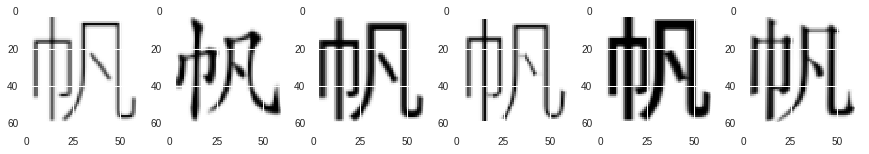

In [15]:
chdir = "dataset/val/n00999/"
files = os.listdir(chdir)

print(files)
_, axs = plt.subplots(1, len(files), figsize=(15,15))

labels = get_label_dict()
for (i,file) in enumerate(files):
  print("show file", file, labels[0])
  axs[i].imshow(imread(chdir + file))
   
plt.show()

In [16]:
!ls dataset

test  train  val
